In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [109]:
Tree(fc.passthrough.TRAINING_MX_700_MY_400).raw_events

50357

In [3]:
signaltree = Tree(fc.passthrough.TESTING_MX_700_MY_400)
qcdtree = Tree(fc.passthrough.QCD_B_List)

treeiter = TreeIter([signaltree,qcdtree])

In [4]:
treeiter.extend(kwargs=build_all_dijets)

[None, None]

In [5]:
from torch_geometric.loader import DataLoader

In [6]:
signaltree.graphs = DataLoader(gnn.Dataset('data/signal-testing',transform=gnn.to_uptri_graph),batch_size=1000*(signaltree.raw_events//5000),num_workers=8)

In [7]:
from torch.utils.data import ConcatDataset


def get_graph_path(fn): return fn.fname.split('/')[-2]


qcdtree.graphs = DataLoader(ConcatDataset([gnn.Dataset(f"data/{fn}", transform=gnn.to_uptri_graph) for fn in map(
    get_graph_path, qcdtree.filelist)]), batch_size=1000*(qcdtree.raw_events//5000), num_workers=8)


In [8]:
model = gnn.GCN.load_from_checkpoint('models/graph_classifier/lightning_logs/version_6/checkpoints/epoch=19-step=16119.ckpt',dataset=signaltree.graphs.dataset)

In [9]:
treeiter.extend(
    kwargs=lambda t: dict(
        dijet_score = ak.unflatten(gnn.predict_dataset_edges(model,t.graphs),ak.num(t.dijet_pt)),
        jet_score = ak.unflatten(gnn.predict_dataset_nodes(model,t.graphs),ak.num(t.jet_pt))
    )
)


[None, None]

In [14]:
varinfo.dijet_score = dict(bins=np.linspace(0,1,30),xlabel="DiJet GNN Score")

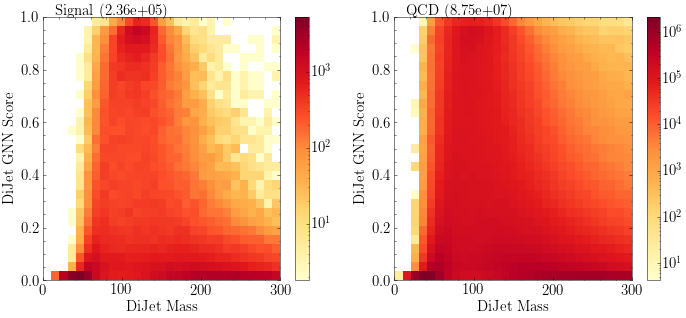

In [79]:
study.quick2d(treeiter,varlist=["dijet_m","dijet_score"],log=True,saveas='gnn-score-vs-dijet-mass')

In [11]:
treeiter.extend(kwargs=lambda t: dict(
    nn_higgs_dm=np.abs(t.nn_higgs_m-125),
    t6_higgs_dm=np.abs(t.t6_higgs_m-125)
)
)


[None, None]

In [98]:
signaltree.extend(
    fake_dijet_score = signaltree.dijet_score[signaltree.dijet_signalId==0],
    true_dijet_score = signaltree.dijet_score[signaltree.dijet_signalId==1]
)

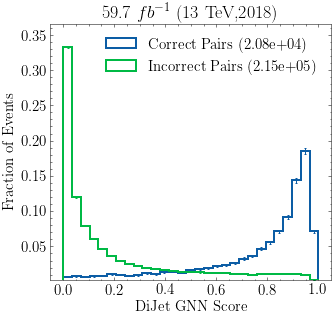

In [105]:
study.overlay([signaltree],varlist=['true_dijet_score','fake_dijet_score'],labels=["Correct Pairs","Incorrect Pairs"],binlist=[varinfo.dijet_score.bins],xlabels=[varinfo.dijet_score.xlabel],density=1,saveas="signal-gnn-scores")

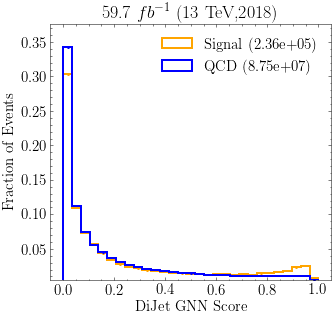

In [108]:
study.quick(treeiter,varlist=['dijet_score'],density=1,saveas='signal-qcd-scores')

In [64]:
treeiter.extend(kwargs=select_higgs)

[None, None]

In [65]:
higgs_metrics = gnn.ROCMetric(signaltree.gnn_higgs_signalId,signaltree.gnn_higgs_score)

In [72]:
jets = get_collection(signaltree,'jet',False)
jets = jets[ak.concatenate([signaltree.gnn_higgs_j1Idx,signaltree.gnn_higgs_j2Idx],axis=-1)]
jet_metrics = gnn.ROCMetric(jets.signalId>-1,jets.score)

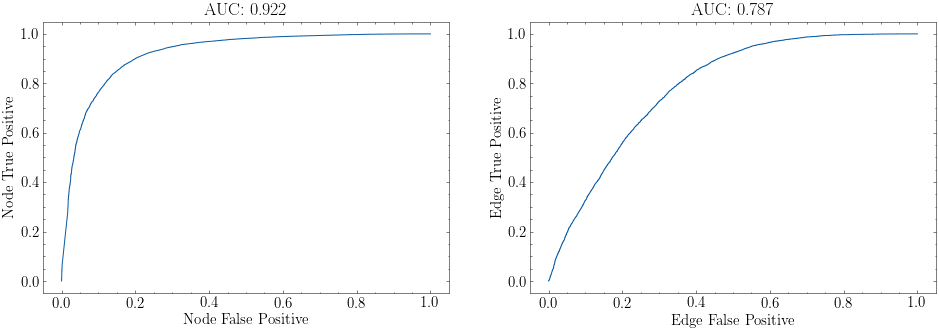

In [78]:
fig,ax = gnn.plot_graph_auroc(jet_metrics,higgs_metrics)
study.save_fig(fig,'graphs','selected-model-roc')

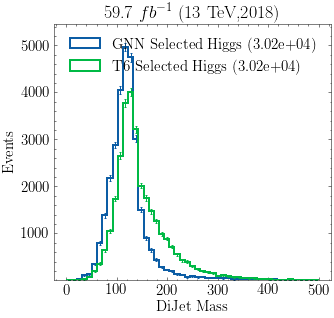

In [80]:
study.overlay([signaltree],varlist=['gnn_higgs_m','t6_higgs_m'],labels=["GNN Selected Higgs","T6 Selected Higgs"],xlabels=["DiJet Mass"],binlist=[np.linspace(0,500,50)],saveas='gnn-vs-t6-mass')

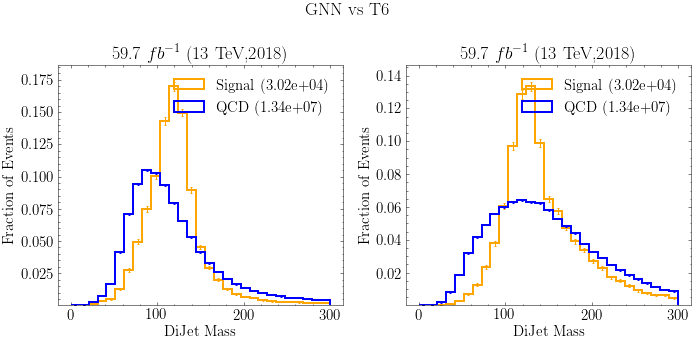

In [82]:
study.quick(treeiter,varlist=['gnn_higgs_m','t6_higgs_m'],xlabels=["GNN Selected DiJet Mass","T6 Selected DiJet Mass"],dim=(1,2),density=1,title='GNN vs T6',saveas='gnn-vs-t6-qcd')

In [88]:
class SoverB:
    def __init__(self,sig,bkg,sig_weights,bkg_weights,cut_range=None):
        if cut_range is None:
            cut_range = min(ak.min(h) for h in (sig,bkg)),max(ak.max(h) for h in (sig,bkg))
        self.cuts = ak.Array(np.linspace(*cut_range,50))
        self.s_rate = np.vectorize(lambda cut : ak.sum(sig_weights[sig>cut]))(self.cuts)
        self.b_rate = np.vectorize(lambda cut : ak.sum(bkg_weights[bkg>cut]))(self.cuts)
        self.s_perc = self.s_rate/ak.sum(sig_weights)
        self.b_perc = self.b_rate/ak.sum(bkg_weights)
        self.soverb = self.s_rate/self.b_rate

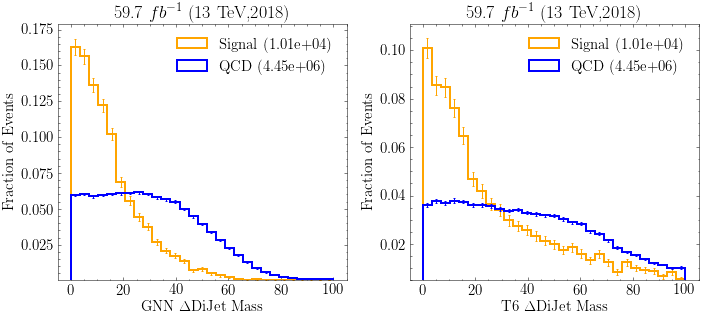

In [85]:
study.quick(treeiter,varlist=['gnn_higgs_dm:0','t6_higgs_dm:0'],xlabels=['GNN $\Delta$DiJet Mass','T6 $\Delta$DiJet Mass'],dim=(1,2),binlist=[np.linspace(0,100,30)]*3,density=1,saveas='gnn-vs-t6-deltaM')

In [89]:
gnn_higgs_dm_metric = SoverB(signaltree.gnn_higgs_dm[:,0],qcdtree.gnn_higgs_dm[:,0],*treeiter.scale,cut_range=(0,100))
t6_higgs_dm_metric = SoverB(signaltree.t6_higgs_dm[:,0],qcdtree.t6_higgs_dm[:,0],*treeiter.scale,cut_range=(0,100))

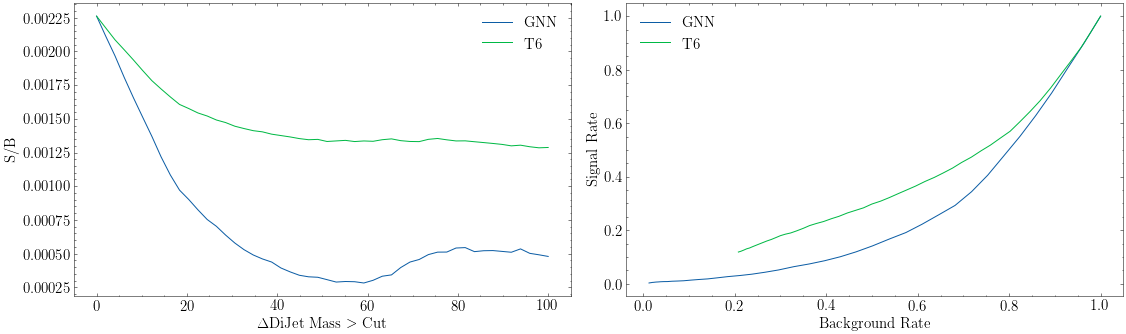

In [96]:
fig,axs = plt.subplots(ncols=2,figsize=(16,5))
labels = ['GNN','T6']
for i,metric in enumerate((gnn_higgs_dm_metric,t6_higgs_dm_metric)):
    graph_simple(metric.cuts,metric.soverb,xlabel="$\Delta$DiJet Mass $>$ Cut",ylabel="S/B",label=labels[i],marker=None,figax=(fig,axs[0]))
    graph_simple(metric.b_perc,metric.s_perc,xlabel="Background Rate",ylabel="Signal Rate",label=labels[i],marker=None,figax=(fig,axs[1]))

fig.tight_layout()
study.save_fig(fig,'cr-selection','dM-cut-performance')